# Recidivism data exploration (SAVRY)

This Python Notebook was created by [ChaTo](http://chato.cl/research/) on January 2019 for educational purposes. It corresponds to a set of 850 juvenile offenders in Catalonia who were evaluated in 2010 using **SAVRY**, a structured risk assessment tool. The data on recidivism indicates if the same people committed a new offence in 2013-2015.

See the [README.md](README.md) file for details on this data.

# Context: evaluating the risk of recidivism

Various risks need to be evaluated in the criminal justice system. These risks include:

* The risk of breaking the conditions of bail, i.e., not returning for trial
* The risk of committing a new crime (*recidivism*)
* The risk of committing a new violent crime (*violent recidivism*)
* The risk of committing an act of violence against another immate or penitentiary personnel in jail (*intrapenitentiary violence*)
* The risk of committing an *administrative violation* such as breaking the conditions of a permit

**Structured risk assessment** corresponds to a family of methodologies for evaluating these risks using a systematic process, typically in which a number of different items are evaluated, and a final decision is taken based on the results of those items. The final decision may be taken by a professional (a *clinical* assessment) or automatically based on the scores in each item (an *actuarial* assessment). Most often, a professional makes a decision based on his/her own evaluation of a defendant and the result of a series of items.

On May 2016, ProPublica, an investigative journalism organizations, published a piece called "[Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencing)", in which a predictive tool for predicting recidivism used in the US, **COMPAS**, was found to be biased against African-Americans. This article prompted several responses and attracted researchers to look at the issues of structured risk assessment in criminal justice.

**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to 850 young offenders in Catalonia. SAVRY contains 24 risk items, in which each item can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points, although in this dataset the highest score attained by an indivdual is 40 points (`sum_all_risk_items`). There is also a score by a professional (`professional_risk_evaluation`) that can be low, moderate, or high.

In this dataset, there is information about whether people committed a new crime 3-5 years after the evaluation. What we ask is to what extent this recidivism can be predicted by using the total SAVRY score as an actuarial assessment, or using the professional risk evaluation. We also ask if there is a better way of combining the SAVRY items than simply adding them, by creating a logistic regression model of risk. Finally, we consider the *fairness* of the resulting instrument.

# Libraries used in this notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

# Load dataset

In [2]:
FILENAME_DATASET = 'savry_cejfe_2017.csv'

df = pd.read_csv(FILENAME_DATASET, sep='\t', index_col=False)
df.head()

,gender,nationality,main_crime_age,criminal_records,main_crime_category,main_crime_is_violent,risk01_previous_violence,risk02_history_nonviolent_offences,risk03_early_violence_before_14,risk04_past_intervention_fail,...,sum_social_risk_items,sum_individual_risk_items,sum_all_risk_items,sum_all_protective_items,professional_risk_evaluation,recidivism,recidivism_number_offences,recidividm_category_first_offence,recidivism_violence_first_offence,recidivism_severity
0,Male,Spanish,17,1 or 2 criminal records,Nonviolent against property,No violent,Moderate,Moderate,Low,Low,...,3,5,12,1,Low,No,0,Not applicable,Not applicable,0
1,Male,Spanish,17,3 to 5 criminal records,Against persons,Violent,Moderate,Moderate,Low,Moderate,...,5,6,19,4,Moderate,Yes,1,Others,No violent,1
2,Male,Foreigner,16,1 or 2 criminal records,Nonviolent against property,No violent,Low,Low,Low,Low,...,4,1,9,3,Low,No,0,Not applicable,Not applicable,0
3,Male,Spanish,17,0 criminal records,Against persons,Violent,Low,Low,Low,Low,...,1,5,9,2,High,No,0,Not applicable,Not applicable,0
4,Male,Spanish,16,3 to 5 criminal records,Nonviolent against property,No violent,Moderate,Moderate,Low,Low,...,2,2,13,0,Moderate,No,0,Not applicable,Not applicable,0


# Descriptive statistics

A few histograms of some relevant attributes, feel free to explore more on your own.

In [3]:
print(len(df))

850


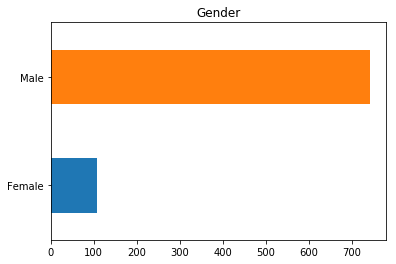

In [4]:
_ = df['gender'].value_counts(ascending=True).plot(kind='barh', title='Gender')

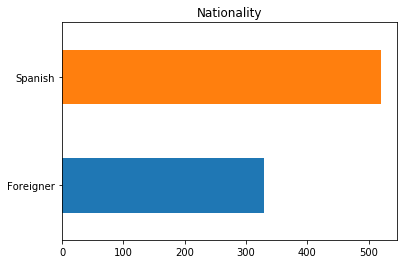

In [5]:
_ = df['nationality'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

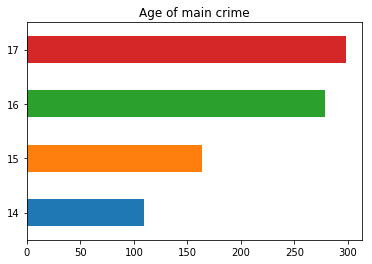

In [6]:
_ = df['main_crime_age'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

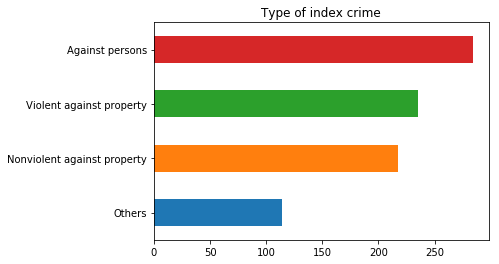

In [7]:
_ = df['main_crime_category'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

# Features that are more connected to recidivism

We use scikit-learn [Chi Squared test](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html). The p-values are interpreted as the strength of the feature, with smaller p-values indicating a better feature.

In [8]:
recidivism_details_columns = ["recidivism_number_offences", "recidividm_category_first_offence", "recidivism_violence_first_offence", "recidivism_severity"]

X = pd.get_dummies(df.drop(columns=["recidivism"] + recidivism_details_columns))
y = pd.get_dummies(df["recidivism"])["Yes"]

chisq, pval = chi2(X, y)

feature_chi2 = pd.Series(pval, X.columns.values)
feature_chi2.sort_values(0).head(10)

sum_all_risk_items                               2.364020e-48
sum_social_risk_items                            3.735096e-19
sum_individual_risk_items                        9.627105e-19
sum_historic_risk_items                          1.171836e-14
sum_all_protective_items                         2.648334e-12
criminal_records_More than 5 criminal records    2.994868e-10
professional_risk_evaluation_High                3.066945e-09
professional_risk_evaluation_Low                 2.545610e-07
risk11_delinquency_peer_group_Low                1.141544e-06
risk11_delinquency_peer_group_High               4.429592e-06
dtype: float64

# Recidivism and human assessment

The column `professional_risk_evaluation` is an evaluation done by a professional expert, based on the results of SAVRY but applying his/her own judgment independently of the obtained score.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

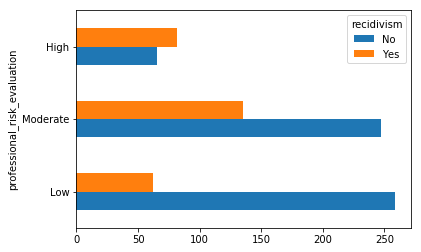

In [9]:
human_ctable = pd.crosstab(df.professional_risk_evaluation, df.recidivism)
human_ctable = human_ctable.reindex(index=["Low", "Moderate", "High"])
_ = human_ctable.plot(kind='barh')

In [10]:
human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index)
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Yes"] / (row["Yes"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

recidivism,No,Yes,recidivism_rate
professional_risk_evaluation,,,
Low,259,62,0.193146
Moderate,247,135,0.353403
High,65,82,0.557823


# Recidivism and overall score in structured assessment

The column `sum_all_risk_items` contains a sum of scores in the risk items of SAVRY.

In [11]:
scores_recidivists = df[df["recidivism"]=='Yes']["sum_all_risk_items"].values
scores_non_recidivists = df[df["recidivism"]=='No']["sum_all_risk_items"].values

In [12]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

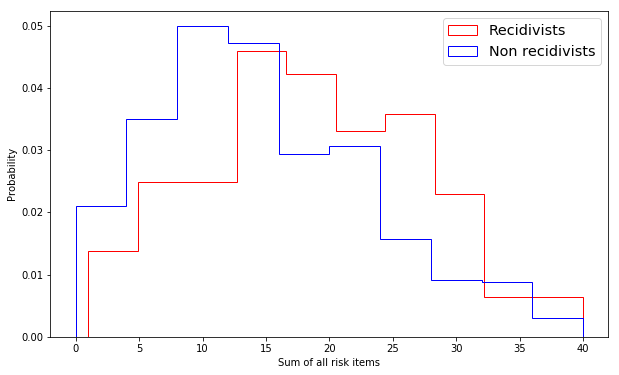

In [13]:
compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [14]:
def draw_roc_curve( ground_truth, predictions, pos_label="Yes"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

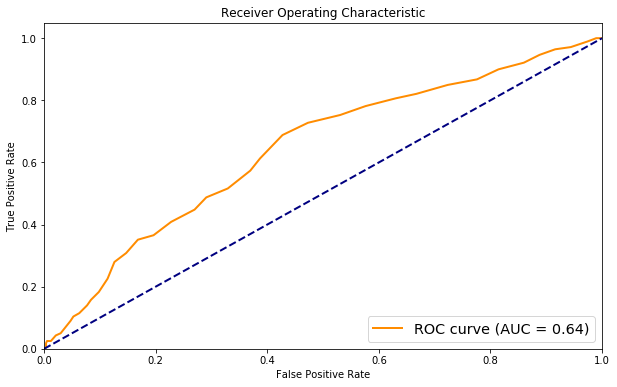

In [15]:
_ = draw_roc_curve(df["recidivism"].values, df["sum_all_risk_items"].values)

# Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [16]:
train, test = train_test_split(df, test_size=0.33)

## Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [17]:
risk_factor_columns = ["risk01_previous_violence", "risk02_history_nonviolent_offences",
                       "risk03_early_violence_before_14", "risk04_past_intervention_fail",
                       "risk05_self_harm_suicide_attempts", "risk06_violence_at_home",
                       "risk07_childhood_mistreatment", "risk08_criminal_parent_caregiver",
                       "risk09_early_separation_parents", "risk10_poor_school_achievement", 
                       "risk11_delinquency_peer_group", "risk12_rejection_peer_group",
                       "risk13_poor_stress_coping", "risk14_poor_parental_skills_parents",
                       "risk15_lack_of_personal_social_support", "risk16_marginalized_environment",
                       "risk17_negative_attitudes", "risk18_risk_taker_impulsive",
                       "risk19_drug_abuse", "risk20_anger_management_issues",
                       "risk21_low_empaty", "risk22_attention_deficit",
                       "risk23_poor_compliance_interventions", "risk24_low_commitment_school"]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["recidivism"]

In [18]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [19]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Yes']
pred24_non_recidivists = pred24_y[test_y == 'No']

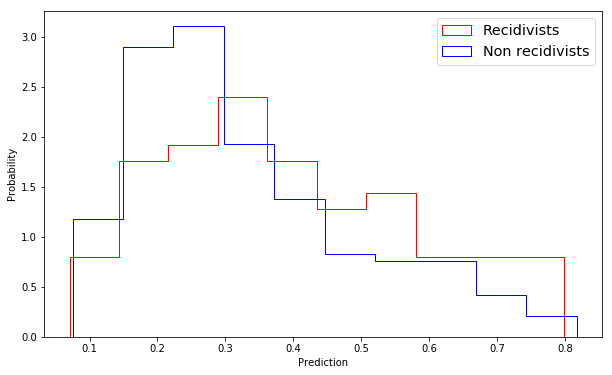

In [20]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

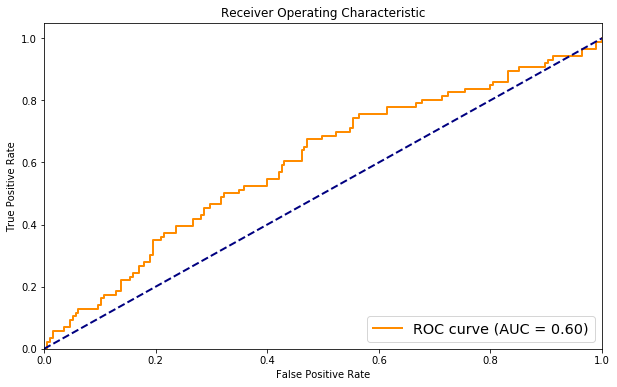

In [21]:
_ = draw_roc_curve(test_y, pred24_y)

## Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [22]:
demographic_columns = ["gender", "nationality", "main_crime_age", "criminal_records",
                       "main_crime_category", "main_crime_is_violent"]
                       
train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["recidivism"]

In [23]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [24]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Yes']
predPH_non_recidivists = predPH_y[test_y == 'No']

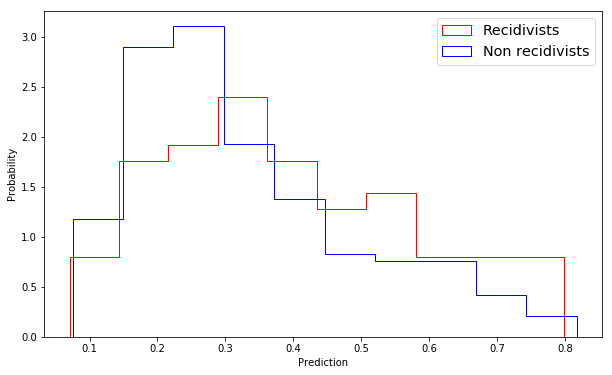

In [25]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

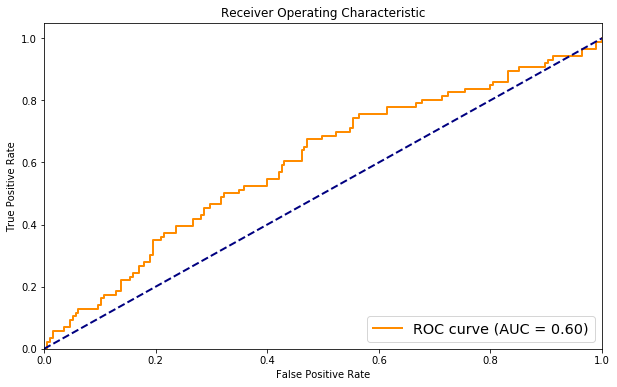

In [26]:
_ = draw_roc_curve(test_y, predPH_y)

## Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [27]:
protective_factor_columns = ["protective01_prosocial_activities", "protective02_strong_social_support",
                             "protective03_strong_link_prosocial_adult", "protective04_positive_attitude_interventions",
                             "protective05_high_commitment_school_or_work", "protective06_perseverant_personality"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["recidivism"]

test_X = pd.get_dummies(test[factors])
test_y = test["recidivism"]

In [28]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [29]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Yes']
predALL_non_recidivists = predALL_y[test_y == 'No']

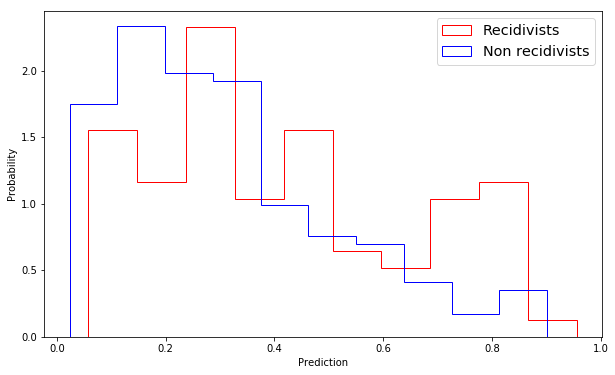

In [30]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

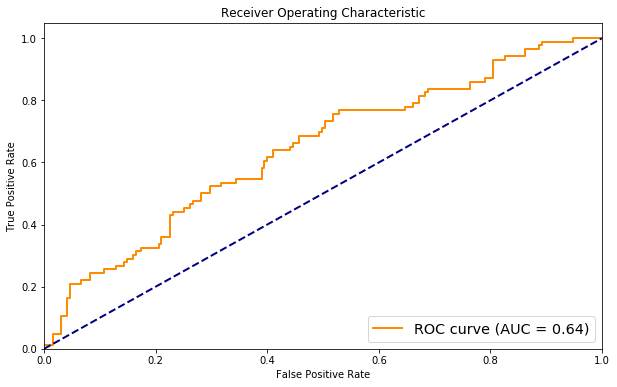

In [31]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism rates are different per sub-populations

We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a much higher rate than nationals.

In [32]:
recidivism_by_gender = pd.crosstab(df.recidivism, df.gender)
recidivism_by_gender

gender,Female,Male
recidivism,,
No,90,481
Yes,18,261


In [33]:
recidivism_by_gender['Female'] = recidivism_by_gender['Female'] / recidivism_by_gender['Female'].sum()
recidivism_by_gender['Male'] = recidivism_by_gender['Male'] / recidivism_by_gender['Male'].sum()
recidivism_by_gender

gender,Female,Male
recidivism,,
No,0.833333,0.648248
Yes,0.166667,0.351752


In [34]:
recidivism_by_nationality = pd.crosstab(df.recidivism, df.nationality)
recidivism_by_nationality

nationality,Foreigner,Spanish
recidivism,,
No,189,382
Yes,141,138


In [35]:
recidivism_by_nationality['Spanish'] = recidivism_by_nationality['Spanish'] / recidivism_by_nationality['Spanish'].sum()
recidivism_by_nationality['Foreigner'] = recidivism_by_nationality['Foreigner'] / recidivism_by_nationality['Foreigner'].sum()
recidivism_by_nationality

nationality,Foreigner,Spanish
recidivism,,
No,0.572727,0.734615
Yes,0.427273,0.265385


# Fairness as equality of error rates

We look at fairness as **equality of error rates**, in this case false positive rates, following [Zafar et al. 2017](https://doi.org/10.1145/3038912.3052660) and [Hardt et al. 2016](http://papers.nips.cc/paper/6373-equality-of-opportunity-in-supervised-learning).

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [36]:
non_recidivists = df[df["recidivism"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists.professional_risk_evaluation, non_recidivists.gender)
non_recidivists_expert_by_gender.reindex(index=["Low", "Moderate", "High"])
non_recidivists_expert_by_gender

gender,Female,Male
professional_risk_evaluation,,
High,9,56
Low,44,215
Moderate,37,210


In [37]:
non_recidivists_expert_by_gender["Male"] = non_recidivists_expert_by_gender["Male"] / non_recidivists_expert_by_gender["Male"].sum()
non_recidivists_expert_by_gender["Female"] = non_recidivists_expert_by_gender["Female"] / non_recidivists_expert_by_gender["Female"].sum()
non_recidivists_expert_by_gender

gender,Female,Male
professional_risk_evaluation,,
High,0.100000,0.116424
Low,0.488889,0.446985
Moderate,0.411111,0.436590


In [38]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists.professional_risk_evaluation, non_recidivists.nationality)
non_recidivists_expert_by_nationality.reindex(index=["Low", "Moderate", "High"])
non_recidivists_expert_by_nationality

nationality,Foreigner,Spanish
professional_risk_evaluation,,
High,22,43
Low,88,171
Moderate,79,168


In [39]:
non_recidivists_expert_by_nationality["Spanish"] = non_recidivists_expert_by_nationality["Spanish"] / non_recidivists_expert_by_nationality["Spanish"].sum()
non_recidivists_expert_by_nationality["Foreigner"] = non_recidivists_expert_by_nationality["Foreigner"] / non_recidivists_expert_by_nationality["Foreigner"].sum()
non_recidivists_expert_by_nationality

nationality,Foreigner,Spanish
professional_risk_evaluation,,
High,0.116402,0.112565
Low,0.465608,0.447644
Moderate,0.417989,0.439791


## Overall SAVRY score and fairness

In [40]:
scores_nationals_non_recidivists = df[(df["recidivism"]=='No') &
                                      (df["nationality"]=='Spanish')]["sum_all_risk_items"].values
scores_foreigners_non_recidivists = df[(df["recidivism"]=='No') &
                                       (df["nationality"]=='Foreigner')]["sum_all_risk_items"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 14.29
Average SAVRY score of foreigner non-recidivist: 14.41


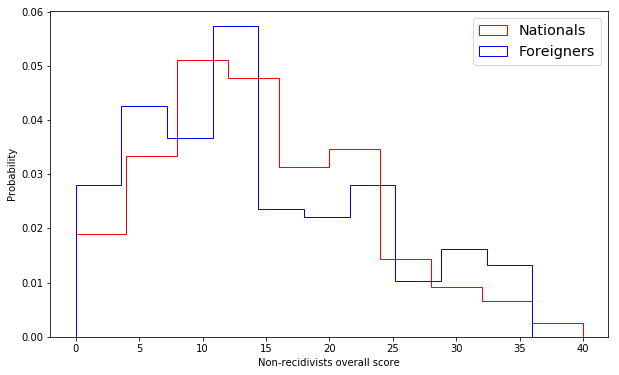

In [41]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="Nationals", label2="Foreigners")

## Fairness using ML score

In [42]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["nationality_Spanish"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["nationality_Foreigner"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.34
Average predicted probability of foreigner non-recidivist: 0.32


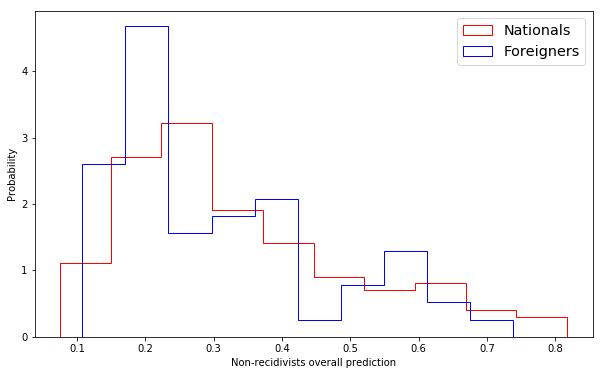

In [43]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Suggested activities


* Determine the relationship between human risk assessment (`professional_risk_evaluation`) and SAVRY total score (`sum_all_risk_items`).

* Consider the prediction of violent crimes only. SAVRY was designed to predict violence, not general recidivism.

* Study false negatives: people given low scores but that did recidivate.

* Find out if some offences are harder to predict than others

* Try using the `recidivism_severity` variable as a target

* Try using cross-validation to have a better evaluation of the logistic regression classifier, or doing repeatedly random splits and averaging the results.

* Try other machine learning models such as SVM or neural networks.

If you find any defect on this dataset or any error in this notebook, please use [ChaTo's contact information](http://chato.cl/blog/en/contact.html). Unfortunately and by necessity I cannot respond to general inquiries about Python or Scikit-Learn.

# Credits

The data file we use is a subset of data obtained by the *Centre d'Estudis Jurídics i Formació Especialitzada* of the Catalan government and released in 2017. Do not use this dataset for research, instead, use the [original dataset](http://cejfe.gencat.cat/en/recerca/cataleg/crono/2017/reincidencia-jj/) and cite the following publication:

```
@misc{cejfe_2017_savry,
 title={La reincid\`{e}ncia en la just\'{i}cia de menors},
 author={Marta Blanch and Manel Capdevila and Marta Ferrer and Berta Framis and \'{U}rsula Ruiz and Judit Mora and Ares Batlle and Berta L\'{o}pez},
 year={2017},
 howpublished={CEJFE},
 url={http://cejfe.gencat.cat/en/recerca/cataleg/crono/2017/reincidencia-jj/}
}
```

This Python Notebook is provided under a [Creative Commons License](https://creativecommons.org/licenses/by/4.0/).